### `Data Preprocessing`
This jupyter notebook contains data set cleaning, tokenization and extracting embeddings (sentence vectors) for a suicidal tweet classifier.

I tried to explain the important parts as much as I can.

For the tokenization and embedding parts, I used the [BERT](https://huggingface.co/docs/transformers/model_doc/bert) model (specifically `bert-base-uncased` model).

In [7]:
import re
import unicodedata
import string

import pandas as pd
import numpy as np
import contractions
import emoji

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stopword_list = stopwords.words('english')

import matplotlib.pyplot as plt

In [8]:
df = pd.read_csv('../data/vader_processed.csv', lineterminator='\n')
df.head()

,Unnamed: 0,vader_sentiment_label,vader_score,tweet
0,0,0,-0.2699,"Wow, my dad yday: “you don’t take those stupid..."
1,1,0,-0.5995,what part of this was really harmfult of a lot...
2,2,1,0.3382,one of the ways I got through my #depression i...
3,3,0,-0.8643,see i wanna do one of them but they all say th...
4,4,0,-0.8316,IS IT clinical depression or is it the palpabl...


In [9]:
df = df.drop(['Unnamed: 0'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24862 entries, 0 to 24861
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   vader_sentiment_label  24862 non-null  int64  
 1   vader_score            24862 non-null  float64
 2   tweet                  24862 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 582.8+ KB


### Couple of things I noticed after the examination of the trimmed data:
1) Most of the tweets contain hashtags, emojis, numbers, and symbols.
2) The overall emotion of the tweet depends on what kind of emoji(s) does it contains. For example, the tweet that contains '😞' emoji is more likely to be depressive.
3) Some of the punctiation marks are repetitive (i.e. '!!' or '??'). These marks could be valuable.
4) There are non-English tweets.
5) Most of the tweets contain tagged users (i.e. '@elon'). A column named 'mentions' in the original copy of the dataset provides the tagged users in the tweet however, not all of them appear in the column.
6) Some of the tweets contain links and hardcoded pictures (i.e. 'pic.twitter.com/tBhxLdatP8'). 

### Some valuable attributes will be saved for later use:
#### These attributes represent tweet's characteristic features. 
- Swearing or offensive word(s) [Integer] => How many are there?
- Tweet length [Integer] => this column will be calculated after removing links.
- Emoji attribute will be break down into two columns: pos_emoji [Boolean], neg_emoji [Boolean]
- URL/Link [Boolean]

### Tweets that contain depressive emojis are more likely to be depressive tweets.
- So, all of the emojis in the dataset must be gathered into a data structure for later analysis.
- Then, most common emojis must be found for categorization.
- Finally, tweets should be checked whether they contain a categorized emoji or not.

In [10]:
df_attributes = df.copy()
emoji_map = {}

def get_emoji_map(tweet, map):
    if type(tweet) == 'float64':
        print(tweet)
    for char in tweet:
        if emoji.is_emoji(char):
            if char not in map.keys():
                map[char] = [emoji.demojize(char), 1]
            else:
                map[char][1] += 1
                
df_attributes['tweet'].apply(get_emoji_map, map=emoji_map)
sorted_emoji_map = sorted(emoji_map.items(), key=lambda x:x[1][1], reverse=True)
sorted_emoji_map

[('😂', [':face_with_tears_of_joy:', 641]),
 ('😭', [':loudly_crying_face:', 419]),
 ('❤', [':red_heart:', 308]),
 ('💔', [':broken_heart:', 219]),
 ('😔', [':pensive_face:', 148]),
 ('🤣', [':rolling_on_the_floor_laughing:', 142]),
 ('🏻', [':light_skin_tone:', 138]),
 ('♀', [':female_sign:', 126]),
 ('😍', [':smiling_face_with_heart-eyes:', 115]),
 ('🙏', [':folded_hands:', 114]),
 ('🏼', [':medium-light_skin_tone:', 113]),
 ('💜', [':purple_heart:', 96]),
 ('🏾', [':medium-dark_skin_tone:', 93]),
 ('🤷', [':person_shrugging:', 92]),
 ('🙃', [':upside-down_face:', 91]),
 ('🏽', [':medium_skin_tone:', 90]),
 ('🙄', [':face_with_rolling_eyes:', 84]),
 ('😢', [':crying_face:', 81]),
 ('😊', [':smiling_face_with_smiling_eyes:', 79]),
 ('😩', [':weary_face:', 79]),
 ('🤔', [':thinking_face:', 78]),
 ('💕', [':two_hearts:', 76]),
 ('♂', [':male_sign:', 72]),
 ('🥺', [':pleading_face:', 67]),
 ('🖤', [':black_heart:', 67]),
 ('🤦', [':person_facepalming:', 62]),
 ('😞', [':disappointed_face:', 61]),
 ('👍', [':thum

In [11]:
# Here I exract positive and negative emojis using the analyzer
analyzer = SentimentIntensityAnalyzer()
emoji_df = pd.DataFrame(columns=['emoji', 'emoji_unicode', 'emoji_count', 'pos_score', 'neg_score', 'neu_score', 'compound_score'])

for key, val in emoji_map.items():
    emoji_df.loc[len(emoji_df.index)] = [key, val[0], val[1], analyzer.polarity_scores(key)['pos'], analyzer.polarity_scores(key)['neg'], analyzer.polarity_scores(key)['neu'], analyzer.polarity_scores(key)['compound']]

pos_df = emoji_df[emoji_df['compound_score'] > 0.27]
neg_df = emoji_df[emoji_df['compound_score'] < -0.27]

pos_emojis = pos_df['emoji_unicode'].tolist()
neg_emojis = neg_df['emoji_unicode'].tolist()

In [12]:
def check_url_link(tweet):
    sentence = tweet.split(' ')
    for word in sentence:
        if word.startswith('https:') or word.startswith('http:'): 
            return 1
    return 0

def check_pos_emoji(tweet):
    for char in tweet:
        if emoji.is_emoji(char) and char in pos_emojis:
            return 1
    return 0

def check_neg_emoji(tweet):
    for char in tweet:
        if emoji.is_emoji(char) and char in neg_emojis:
            return 1
    return 0

def get_tweet_length(tweet):
    sentence = tweet.split(' ')
    res = " "
    
    for word in sentence:
        if word.startswith('https:') or word.startswith('http:') or word.startswith('pic.twitter.com'):
            sentence.remove(word)
    return len(res.join(sentence))

def get_profanity_words(tweet):
    cleaned_tweet = re.sub(r'[^\w\s]', '', tweet)
    sentence = cleaned_tweet.split(' ') 
    profanity_wordlist = np.loadtxt('../data/profanity_wordlist.txt', dtype='str')
    count = 0
    
    for word in sentence:
        if word.lower() in profanity_wordlist:
            count += 1
    return count

In [14]:
tweet_num = 22913

tweet = df_attributes['tweet'][tweet_num]
vader_score = df_attributes['vader_sentiment_label'][tweet_num]

print(f"{tweet} - {vader_score}\n")
print(f"url link: {check_url_link(tweet)}")
print(f"positive emoji: {check_pos_emoji(tweet)}")
print(f"negative emoji: {check_neg_emoji(tweet)}")
print(f"tweet length: {get_tweet_length(tweet)}")
print(f"profanity word: {get_profanity_words(tweet)}")

I go into serious depression when baseball  ends and we have to wait for the next athletic season - 0

url link: 0
positive emoji: 0
negative emoji: 0
tweet length: 97
profanity word: 0


In [15]:
df_attributes['tweet_length'] = df_attributes['tweet'].apply(get_tweet_length)
df_attributes['url_link'] = df_attributes['tweet'].apply(check_url_link)
df_attributes['pos_emoji'] = df_attributes['tweet'].apply(check_pos_emoji)
df_attributes['neg_emoji'] = df_attributes['tweet'].apply(check_neg_emoji)
df_attributes['profanity_word'] = df_attributes['tweet'].apply(get_profanity_words)

In [16]:
df_attributes

,vader_sentiment_label,vader_score,tweet,tweet_length,url_link,pos_emoji,neg_emoji,profanity_word
0,0,-0.2699,"Wow, my dad yday: “you don’t take those stupid...",278,0,0,0,0
1,0,-0.5995,what part of this was really harmfult of a lot...,274,0,0,0,0
2,1,0.3382,one of the ways I got through my #depression i...,208,0,0,0,0
3,0,-0.8643,see i wanna do one of them but they all say th...,114,0,0,0,0
4,0,-0.8316,IS IT clinical depression or is it the palpabl...,78,0,0,0,0
...,...,...,...,...,...,...,...,...
24857,0,-0.5719,Depression is real,18,0,0,0,0
24858,0,-0.5060,Even though Tropical Depression Barry did not ...,245,1,0,0,0
24859,0,-0.7906,https://medtally.com/post/cluster-analysis-wi...,83,1,0,0,0
24860,0,-0.7783,مش لاقى أى مبرر لل sudden depression attack ال...,89,0,0,0,0


### Data Preprocessing
Data should be processed in a way that it can be vectorized for tokenization.

(Note: At this point, not so sure about removing hashtags. Maybe will delete later)

- All tweets converted into lowercase.
- URL(s) removed from tweets. Such as, "https...., pic.twitter.com/..."
- All contractions are expanded.
- Accented chars are converted into original forms. Such as, "á": "a"
- All emojis, mentions and digits are removed.
- All punctuation marks and special characters (i.e. £, $) are removed.
- All stopwords are removed.
- Finally, stemming is applied for a more robust data set.

In [17]:
df_clean = df_attributes.copy()

In [18]:
def to_lowercase(tweet):
    return tweet.lower()

In [19]:
# remove url links such as, 'https://...', 'http://...', or 'pic.twitter...'
def remove_url(tweet):
    tweet = re.sub(r'http\S+', '', tweet)
    tweet = re.sub(r'pic\.twitter\.com\S+', '', tweet)
    tweet = re.sub(r'www.+', '', tweet)
    tweet = tweet.replace(u'\xa0', u' ')
    
    return tweet.strip()

In [20]:
# this dictionary contains contractions and their expanded forms
contractions_dict = {
  "brb": "be right back",
  "btw": "by the way",
  "cant": "can not",
  "dont": "do not",
  "doesnt": "doesn ot",
  "didnt": "did not",
  "hasnt": "has not",
  "havent": "have not",
  "heres": "here is",
  "howd": "how did",
  "howve": "how have",  
  "hows": "how is",
  "id": "i would",
  "ive": "i have",
  "isnt": "is not",
  "itd": "it would",
  "itll": "it will",
  "its": "it iss",
  "kys": "kill yourself",  
  "lets": "let us", 
  "ngl": "not gonna lie",
  "omg": "oh my god",
  "omfg": "oh my fucking god",  
  "shes": "she is",
  "stfu": "shut the fuck up",  
  "thats": "that is",
  "theres": "there is",
  "theyd": "they would",
  "theyll": "they will",
  "theyre": "they are",
  "theyve": "they have",
  "thisll": "this will",  
  "uve": "you have",  
  "wasnt": "was not",
  "wed": "we would",
  "werent": "were not",
  "whatll": "what will",
  "what're": "what are",
  "whats": "what is",
  "whatve": "what have",
  "whens": "when is",
  "whered": "where would",
  "wheres": "where is",
  "whereve": "where have",
  "wholl": "who will",
  "who'll've": "who will have",
  "whos": "who is",
  "whove": "who have",
  "whys": "why is",
  "whyve": "why have",
  "will've": "will have",
  "wont": "will not",
  "wouldve": "would have",
  "wouldnt": "would not",
  "yall": "you all",
  "yalls": "you alls",
  "youd": "you would",
  "youll": "you will",
  "youllve": "you will have",
  "youre": "you are",
  "youve": "you have",
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "here's": "here is", 
  "how'd": "how did",
  "how'd'y": "how do you",
  "how've": "how have",  
  "how'll": "how will",
  "how's": "how is",
  "i'd": "i would",
  "i'd've": "i would have",
  "i'll": "i will",
  "i'll've": "i will have",
  "i'm": "i am",
  "i've": "i have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "seen't": "see not",  
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that'll": "that will", 
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "this'll": "this will",  
  "to've": "to have",
  "u've": "you have",  
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "ya'll": "you all",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "yday": "yesterday",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you will",
  "you'll've": "you will have",
  "you're": "you are",
  "you've": "you have"
}
"""
    create a regular expression pattern using 'contractions_dict'
    this pattern is used to identify contractions in the given input string
"""
contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))

"""
    replaces all occurrences of contractions in the input string with their expanded forms
    'replace' function is used as the replacement function, and it's applied to each match found by the regular expression
"""
def expand_contractions(tweet, contractions_dict=contractions_dict):
    # takes a 'match' object and returns corresponded expansion form
    tweet = tweet.replace("’", "'")
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, tweet)

In [21]:
"""
    convert accent characters into standard ASCII characters
    Such as: résumé, café, prótest, divorcé => resume, cafe, protest, divorce
"""
def convert_accented_chars(tweet):
    return unicodedata.normalize('NFKD', tweet).encode('ascii', 'ignore').decode('utf-8', 'ignore')

In [22]:
def remove_emojis(tweet):
    return ''.join(char for char in tweet if not emoji.is_emoji(char))

In [23]:
# remove mentions (and tags ?)
def remove_mentions(tweet):
    return re.sub(r'@\S*', '', tweet)

In [24]:
# remove digits
def remove_digits(tweet):
    return ''.join(char for char in tweet if not char.isdigit())

In [25]:
def remove_special_characters(tweet):
    pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
    return re.sub(pattern, '', tweet)

In [26]:
def remove_punctuation(tweet):
    return ''.join([char for char in tweet if char not in string.punctuation])

In [27]:
def remove_stopwords(tweet):
    word_tokens = nltk.word_tokenize(tweet) 
    filtered_sentence = [w for w in word_tokens if not w in stopword_list]
    tweet = ' '.join(filtered_sentence)
    return tweet

In [28]:
df_clean['tweet'] = df_clean['tweet'].apply(to_lowercase)
df_clean['tweet'] = df_clean['tweet'].apply(remove_url)
df_clean['tweet'] = df_clean['tweet'].apply(expand_contractions)
df_clean['tweet'] = df_clean['tweet'].apply(convert_accented_chars)
df_clean['tweet'] = df_clean['tweet'].apply(remove_emojis)
df_clean['tweet'] = df_clean['tweet'].apply(remove_mentions)
df_clean['tweet'] = df_clean['tweet'].apply(remove_digits)
df_clean['tweet'] = df_clean['tweet'].apply(remove_special_characters)
df_clean['tweet'] = df_clean['tweet'].apply(remove_punctuation)
df_clean['tweet'] = df_clean['tweet'].apply(remove_stopwords)

df_clean.to_csv('test.csv')

In [30]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24862 entries, 0 to 24861
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   vader_sentiment_label  24862 non-null  int64  
 1   vader_score            24862 non-null  float64
 2   tweet                  24862 non-null  object 
 3   tweet_length           24862 non-null  int64  
 4   url_link               24862 non-null  int64  
 5   pos_emoji              24862 non-null  int64  
 6   neg_emoji              24862 non-null  int64  
 7   profanity_word         24862 non-null  int64  
dtypes: float64(1), int64(6), object(1)
memory usage: 1.5+ MB


### Some tweets remained as an empty string after unnecessary parts were removed.
Such as:
    "💜💜💜 @NewYorkTimes" => " "

These rows must be removed as well.

In [31]:
df_clean[df_clean['tweet'].str.len() == 0]

,vader_sentiment_label,vader_score,tweet,tweet_length,url_link,pos_emoji,neg_emoji,profanity_word
64,0,-0.3182,,17,0,0,0,0
155,0,0.0000,,55,0,0,0,0
201,0,0.0000,,51,0,0,0,0
383,1,0.4939,,45,0,0,0,0
568,0,0.0000,,33,0,0,0,0
...,...,...,...,...,...,...,...,...
24698,1,0.9274,,3,0,0,0,0
24725,0,0.0000,,19,0,0,0,0
24762,0,0.0000,,14,0,0,0,0
24829,0,0.0000,,29,0,0,0,0


In [ ]:
# remove row...s where 'tweet' column is empty
df_clean = df_clean[df_clean['tweet'].str.len() > 0]

len(df_clean.index)

In [33]:
non_depressive_tweets = df_clean.loc[df_clean['vader_sentiment_label'] == 1]['tweet']
depressive_tweets = df_clean.loc[df_clean['vader_sentiment_label'] == 0]['tweet']

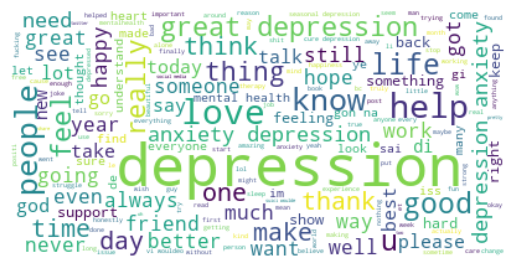

In [39]:
non_depressive_test = " ".join(tweet for tweet in non_depressive_tweets)
depressive_test = " ".join(tweet for tweet in depressive_tweets)

stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(non_depressive_test)
wordcloud.to_file("../data/non-depressive.png")

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

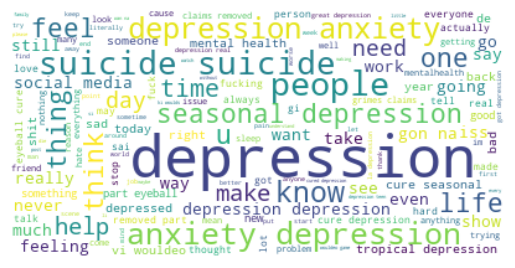

In [54]:
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(depressive_test)
wordcloud.to_file("../data/depressive.png")

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

After cleaning the text, the text should be processed with Stemmer before tokenization.

In [25]:
stemmer = PorterStemmer()

def get_stem(tweet, stemmer=stemmer):
    return ' '.join([stemmer.stem(word) for word in tweet.split()])

In [26]:
df_clean['tweet'] = df_clean['tweet'].apply(get_stem) 
df_clean.to_csv('../data/preprocessed_tweets.csv')